In [2]:
!pip install imbalanced-learn


In [7]:
pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn joblib streamlit shap notebook ipykernel


   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 616.4 kB/s  0:00:01
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 523.1 kB/s eta 0:0

In [12]:
from imblearn.over_sampling import SMOTE
print("SMOTE OK")


SMOTE OK


In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)


In [14]:
df = pd.read_csv("Palo Alto Networks.csv")

df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [15]:
df = df.drop(columns=['EmployeeNumber','EmployeeCount','Over18','StandardHours'], errors='ignore')

df.shape


(1470, 31)

In [16]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

print(y.value_counts())


Attrition
0    1233
1     237
Name: count, dtype: int64


In [17]:
X["IncomeExperienceRatio"] = X["MonthlyIncome"] / (X["TotalWorkingYears"] + 1)
X["PromotionDelay"] = X["YearsSinceLastPromotion"]

X["EngagementScore"] = (
    X["JobSatisfaction"] +
    X["EnvironmentSatisfaction"] +
    X["JobInvolvement"] +
    X["RelationshipSatisfaction"]
)

X["WorkStressScore"] = (
    (X["OverTime"] == "Yes").astype(int) +
    (X["BusinessTravel"] == "Travel_Frequently").astype(int) +
    X["DistanceFromHome"]
)

X["StabilityScore"] = X["YearsWithCurrManager"] + X["YearsAtCompany"]


In [18]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

print("Categorical:", len(cat_cols))
print("Numerical:", len(num_cols))


Categorical: 7
Numerical: 28


In [19]:
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [21]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_prep, y_train)

print("Before:", y_train.value_counts())
print("After:", pd.Series(y_train_bal).value_counts())


Before: Attrition
0    986
1    190
Name: count, dtype: int64
After: Attrition
0    986
1    986
Name: count, dtype: int64


In [22]:
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

log_model.fit(X_train_bal, y_train_bal)
rf_model.fit(X_train_bal, y_train_bal)
gb_model.fit(X_train_bal, y_train_bal)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [23]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, probs))

    return probs


In [24]:
print("LOGISTIC REGRESSION")
log_probs = evaluate(log_model, X_test_prep, y_test)

print("\nRANDOM FOREST")
rf_probs = evaluate(rf_model, X_test_prep, y_test)

print("\nGRADIENT BOOSTING")
gb_probs = evaluate(gb_model, X_test_prep, y_test)


LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       247
           1       0.36      0.60      0.45        47

    accuracy                           0.77       294
   macro avg       0.64      0.70      0.65       294
weighted avg       0.82      0.77      0.79       294

ROC AUC: 0.7986045309673531

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       247
           1       0.55      0.23      0.33        47

    accuracy                           0.85       294
   macro avg       0.71      0.60      0.62       294
weighted avg       0.82      0.85      0.82       294

ROC AUC: 0.8156602635885951

GRADIENT BOOSTING
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       247
           1       0.56      0.32      0.41        47

    accuracy                           0.85       294
   macro avg      

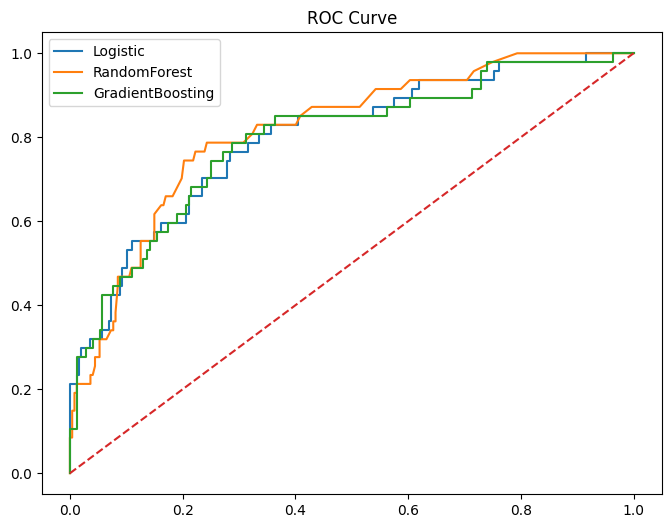

In [25]:
plt.figure(figsize=(8,6))

for name, probs in zip(
    ["Logistic","RandomForest","GradientBoosting"],
    [log_probs, rf_probs, gb_probs]
):
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve")
plt.show()


In [27]:
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

final_model.fit(X, y)

joblib.dump(final_model, "attrition_risk_model.pkl")

print("Model saved as attrition_risk_model.pkl")


Model saved as attrition_risk_model.pkl
